In [1]:
# 1. Install required packages
!pip install pandas matplotlib seaborn tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.3 MB/s eta 0:00:00


In [20]:
# 2. Import libraries
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
import re
import numpy as np
from urllib.parse import urlparse
from wordcloud import WordCloud

In [4]:
# 3. Upload and load data
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving test.txt to test.txt


In [6]:
# Load data with strict validation
df = pd.read_csv(filename,
                 sep='\t+',  # Handles multiple tabs
                 engine='python',
                 header=None,
                 names=['label', 'url'],
                 on_bad_lines='warn')

# Clean labels
df['label'] = df['label'].str.strip().str.lower()
valid_labels = ['phishing', 'legitimate']
df = df[df['label'].isin(valid_labels)]

In [7]:
# 4. Extract URL components with validation
def extract_components(url):
    try:
        ext = tldextract.extract(url.strip())
        parsed = urlparse(url)
        return {
            'domain_length': len(ext.domain),
            'subdomain_length': len(ext.subdomain),
            'path_length': len(parsed.path),
            'query_length': len(parsed.query)
        }
    except:
        return {col: 0 for col in ['domain_length', 'subdomain_length', 'path_length', 'query_length']}

# Apply extraction
components_df = df['url'].apply(lambda x: pd.Series(extract_components(x)))
df = pd.concat([df, components_df], axis=1).dropna()

In [8]:
# 5. Add full URL length calculation
df['full_length'] = df['url'].str.len()

In [9]:
# 6. Verify data structure
print("Processed Data Sample:")
print(df[['label', 'url', 'full_length', 'domain_length']].head())

Processed Data Sample:
        label                                                url  full_length  \
0    phishing    http://www.bartekbitner.pl/libraries/fof/-/din7           47   
1    phishing  http://www.isalechina.com/_db_backups/SecureDo...           54   
2  legitimate  https://eheadspace.org.au/headspace-centres/mu...           58   
3    phishing  http://www.idolhairsalon.com/google/free/free2...           96   
4  legitimate  https://hedgebrook.org/six-questions-for-hanna...           58   

   domain_length  
0             12  
1             10  
2             10  
3             13  
4             10  


In [10]:
# 7. Create visualizations
def plot_component_analysis(component, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=df,
        x=component,
        hue='label',
        bins=30,
        kde=True,
        palette={'phishing': '#ff474c', 'legitimate': '#0095b6'},
        common_norm=False,
        alpha=0.7
    )
    plt.title(f'Distribution of {title} Lengths', pad=20)
    plt.xlabel(f'{title} Length (characters)', labelpad=15)
    plt.ylabel('Density', labelpad=15)
    plt.grid(alpha=0.3)
    plt.show()

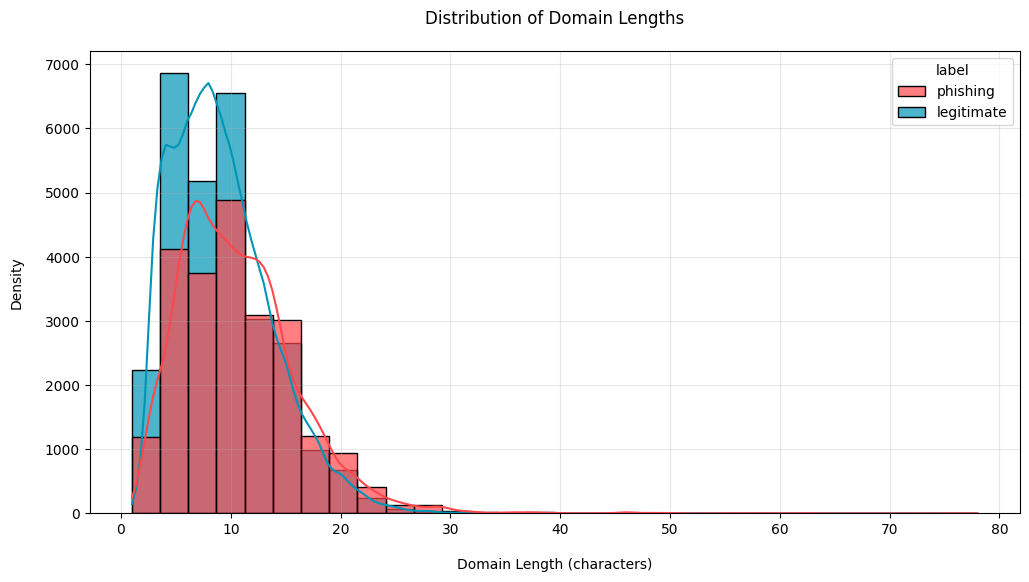


Domain Statistics:
              count       mean       std  min  25%   50%   75%   max
label                                                               
legitimate  28532.0   9.152986  4.527870  1.0  6.0   8.0  12.0  37.0
phishing    22977.0  10.672760  5.414868  1.0  7.0  10.0  14.0  78.0




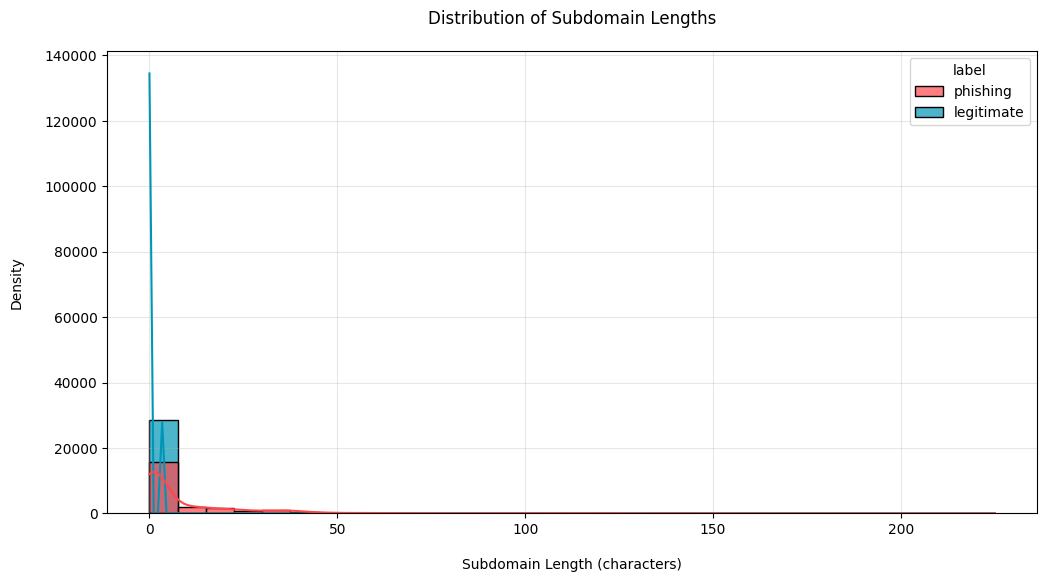


Subdomain Statistics:
              count       mean        std  min  25%  50%   75%    max
label                                                                
legitimate  28532.0   2.187018   1.353764  0.0  0.0  3.0   3.0   17.0
phishing    22977.0  11.639944  24.120637  0.0  0.0  3.0  13.0  225.0




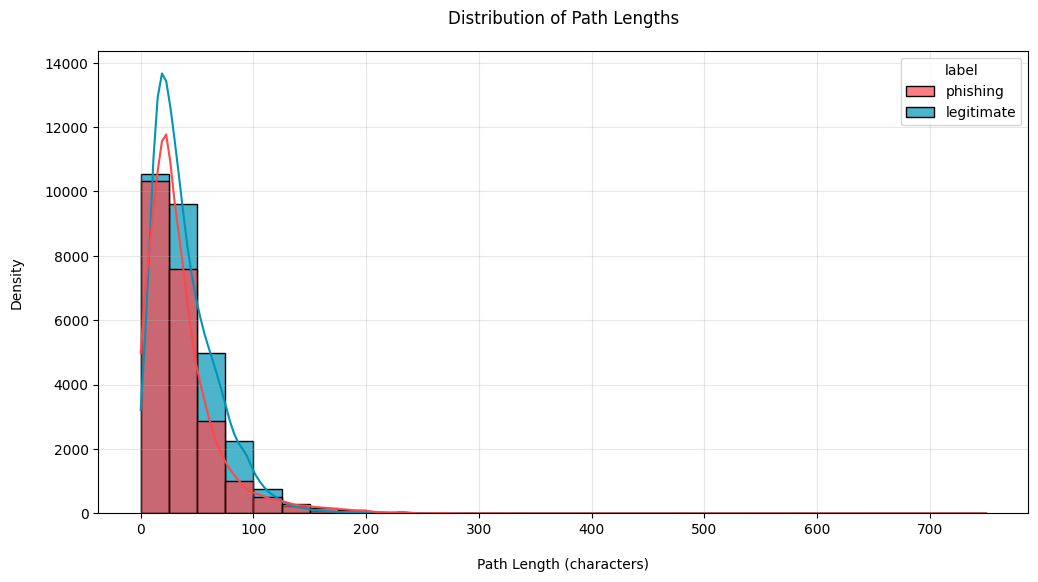


Path Statistics:
              count       mean        std  min   25%   50%   75%    max
label                                                                  
legitimate  28532.0  39.855110  30.826647  0.0  18.0  32.0  55.0  631.0
phishing    22977.0  36.062715  33.662703  0.0  16.0  27.0  46.0  750.0




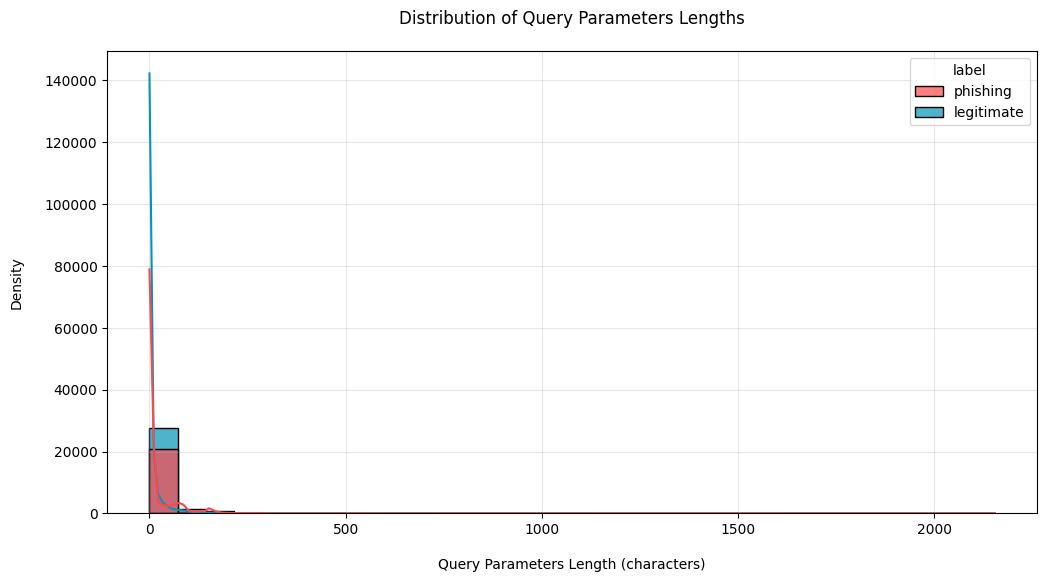


Query Parameters Statistics:
              count       mean        std  min  25%  50%  75%     max
label                                                                
legitimate  28532.0   8.589654  37.328657  0.0  0.0  0.0  0.0  1191.0
phishing    22977.0  16.902294  49.103262  0.0  0.0  0.0  0.0  2155.0




In [11]:
# 8. Generate all plots
components = {
    'domain_length': 'Domain',
    'subdomain_length': 'Subdomain',
    'path_length': 'Path',
    'query_length': 'Query Parameters'
}

for col, title in components.items():
    plot_component_analysis(col, title)
    print(f"\n{title} Statistics:")
    print(df.groupby('label')[col].describe())
    print("\n" + "="*60 + "\n")

/tmp/ipython-input-3658006549.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='full_length', data=df,


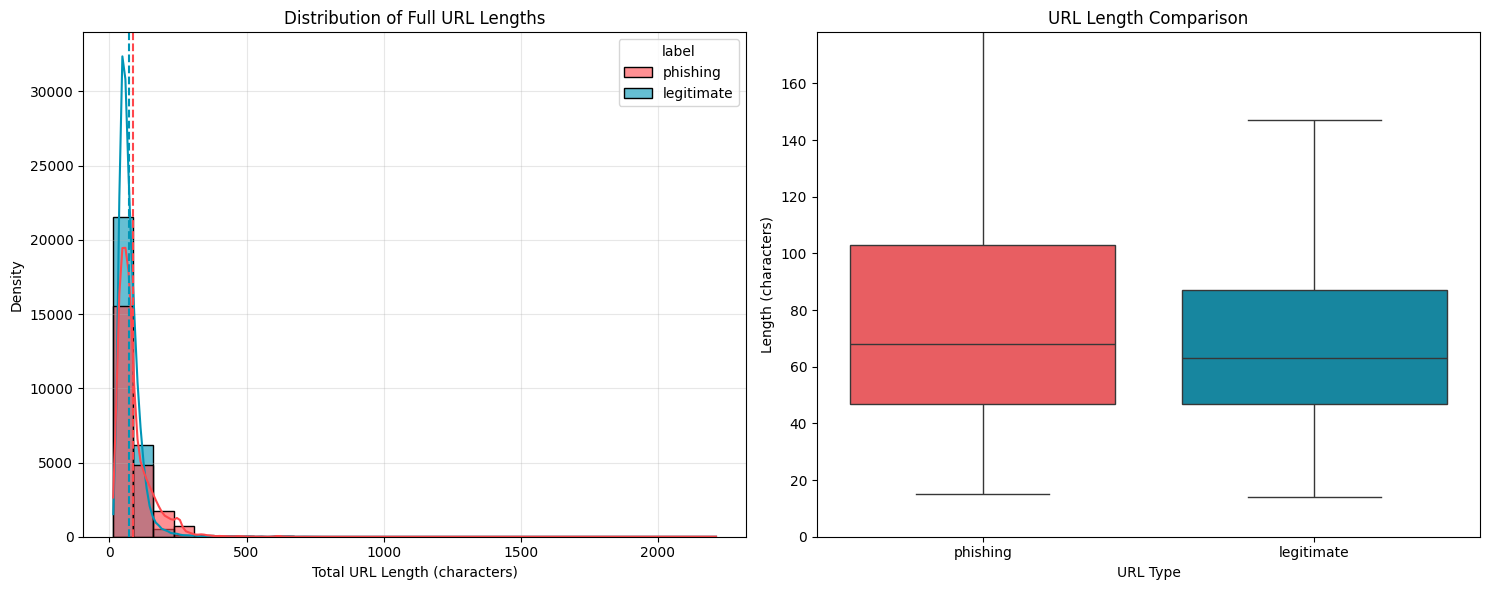


Full URL Length Statistics:
              count       mean        std   min   50%     max
label                                                        
legitimate  28532.0  72.496670  46.129452  14.0  63.0  1222.0
phishing    22977.0  87.328894  66.410302  15.0  68.0  2213.0


In [15]:
# 9. Full URL length comparison
plt.figure(figsize=(15, 6))

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='full_length', hue='label',
             bins=30, kde=True, palette={'phishing': '#ff474c', 'legitimate': '#0095b6'},
             common_norm=False, alpha=0.6)
plt.title('Distribution of Full URL Lengths')
plt.xlabel('Total URL Length (characters)')
plt.ylabel('Density')
plt.grid(alpha=0.3)

# Add mean lines
plt.axvline(df[df['label']=='phishing']['full_length'].mean(), color='#ff474c', linestyle='--')
plt.axvline(df[df['label']=='legitimate']['full_length'].mean(), color='#0095b6', linestyle='--')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='full_length', data=df,
           palette={'phishing': '#ff474c', 'legitimate': '#0095b6'},
           showfliers=False)
plt.title('URL Length Comparison')
plt.xlabel('URL Type')
plt.ylabel('Length (characters)')
plt.ylim(0, df['full_length'].quantile(0.95))  # Show up to 95th percentile

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nFull URL Length Statistics:")
print(df.groupby('label')['full_length'].describe()[['count', 'mean', 'std', 'min', '50%', 'max']])

<Figure size 1200x600 with 0 Axes>

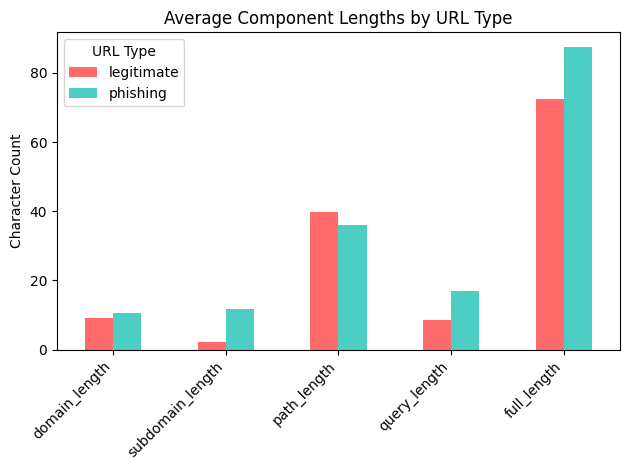

In [16]:
#Component Comparison Bar Chart
plt.figure(figsize=(12, 6))
component_means = df.groupby('label')[['domain_length', 'subdomain_length',
                                      'path_length', 'query_length', 'full_length']].mean().T
component_means.plot(kind='bar', color=['#ff6b6b', '#4ecdc4'])
plt.title('Average Component Lengths by URL Type')
plt.ylabel('Character Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='URL Type')
plt.tight_layout()
plt.show()

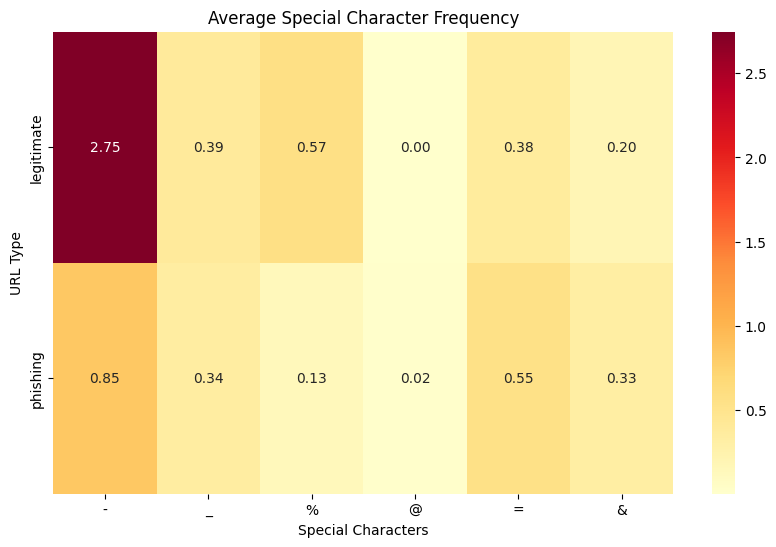

In [21]:
#Special Character Heatmap
special_chars = ['-', '_', '%', '@', '=', '&']
char_counts = df.assign(**{char: df.url.str.count(re.escape(char)) for char in special_chars})
char_matrix = char_counts.groupby('label')[special_chars].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(char_matrix, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Average Special Character Frequency')
plt.ylabel('URL Type')
plt.xlabel('Special Characters')
plt.show()

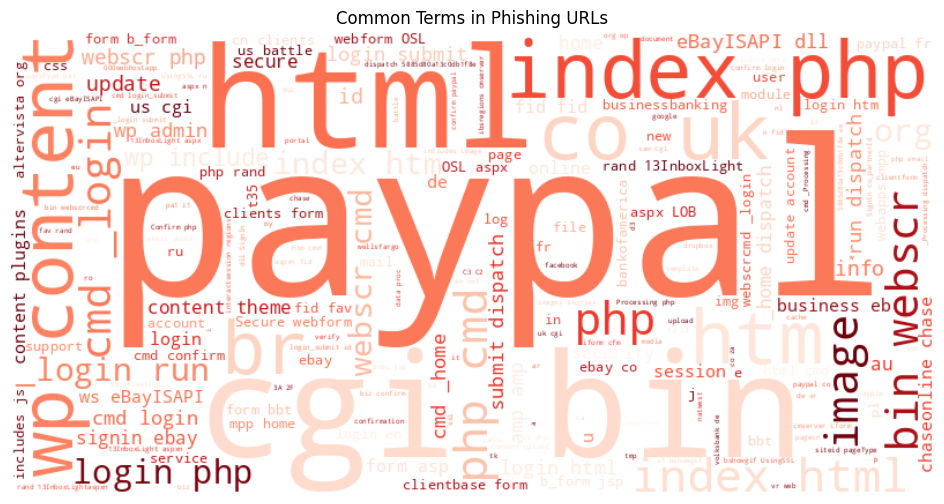

In [18]:
#Phishing Word Cloud
phishing_text = ' '.join(df[df.label=='phishing'].url)
wordcloud = WordCloud(width=800, height=400,
                     background_color='white', colormap='Reds',
                     stopwords={'http','https','www','com','net'}).generate(phishing_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Terms in Phishing URLs')
plt.show()

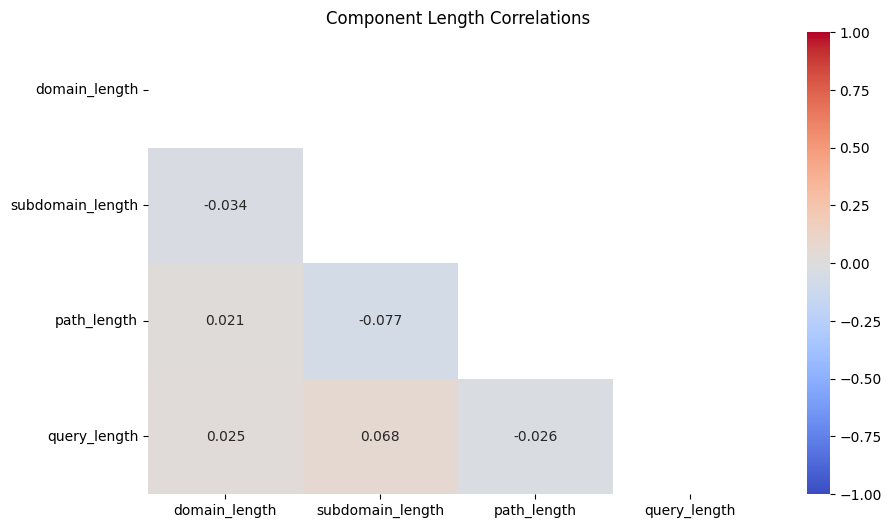

In [22]:
#Correlation Matrix
corr_matrix = df[['domain_length', 'subdomain_length',
                 'path_length', 'query_length']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
           vmin=-1, vmax=1, mask=np.triu(np.ones_like(corr_matrix)))
plt.title('Component Length Correlations')
plt.show()